# Solving Sudoku using Grover's Algorithm <a id="sudoku"></a>

We will now solve a simple problem using Grover's algorithm, for which we do not necessarily know the solution beforehand. Our problem is a 2×2 binary sudoku, which in our case has two simple rules:

- No column may contain the same value twice
- No row may contain the same value twice

If we assign each square in our sudoku to a variable like so:

![2×2 binary sudoku, with each square allocated to a different variable](images/binary_sudoku.png)

we want our circuit to output a solution to this sudoku.

Note that, while this approach of using Grover's algorithm to solve this problem is not practical (you can probably find the solution in your head!), the purpose of this example is to demonstrate the conversion of classical [decision problems](https://en.wikipedia.org/wiki/Decision_problem) into oracles for Grover's algorithm.

### Turning the Problem into a Circuit

We want to create an oracle that will help us solve this problem, and we will start by creating a circuit that identifies a correct solution, we simply need to create a _classical_ function on a quantum circuit that checks whether the state of our variable bits is a valid solution.

Since we need to check down both columns and across both rows, there are 4 conditions we need to check:

```
v0 ≠ v1   # check along top row
v2 ≠ v3   # check along bottom row
v0 ≠ v2   # check down left column
v1 ≠ v3   # check down right column
```

1. Create a reversible classical circuit that identifies a correct solution
2. Turn this circuit into an oracle
3. Use Grover's algorithm to solve this oracle



In [1]:
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit.circuit.library.standard_gates import XGate, ZGate
from qiskit.primitives import StatevectorSampler
from qiskit_aer import AerSimulator
import numpy as np
from random import Random
from qiskit.visualization import plot_histogram

In [2]:
np.matrix([[0]]).shape

(1, 1)

In [3]:

def clauses(qc):
    # initially all true
    for qubit in range(4,8):
        classical_oracle.x(qubit)

    #essentially:
    # true untill proven otherwise
    # if both are the same, not it
    # we invert it once to check case 00 as well.

    
    # v0 != v1
    #sdtored into v4
    qc.ccx(0, 1, 4) 
    qc.x(0) # to catch both 00 and 11
    qc.x(1)
    qc.ccx(0, 1, 4)
    qc.x(0) # undo
    qc.x(1)
    qc.barrier()

    # v2 != v3
    #sdtored into v5
    qc.ccx(2, 3, 5) 
    qc.x(2) # to catch both 00 and 11
    qc.x(3)
    qc.ccx(2, 3, 5)
    qc.x(2) # undo
    qc.x(3)
    qc.barrier()

    # v0 != v2
    #sdtored into v6
    qc.ccx(0, 2, 6) 
    qc.x(0) # to catch both 00 and 11
    qc.x(2)
    qc.ccx(0, 2, 6)
    qc.x(0) # undo
    qc.x(2)
    qc.barrier()

    # v1 != v3
    #sdtored into 7
    qc.ccx(1, 3, 7) 
    qc.x(3) # to catch both 00 and 11
    qc.x(1)
    qc.ccx(1, 3, 7)
    qc.x(3) # undo
    qc.x(1)
    qc.barrier()

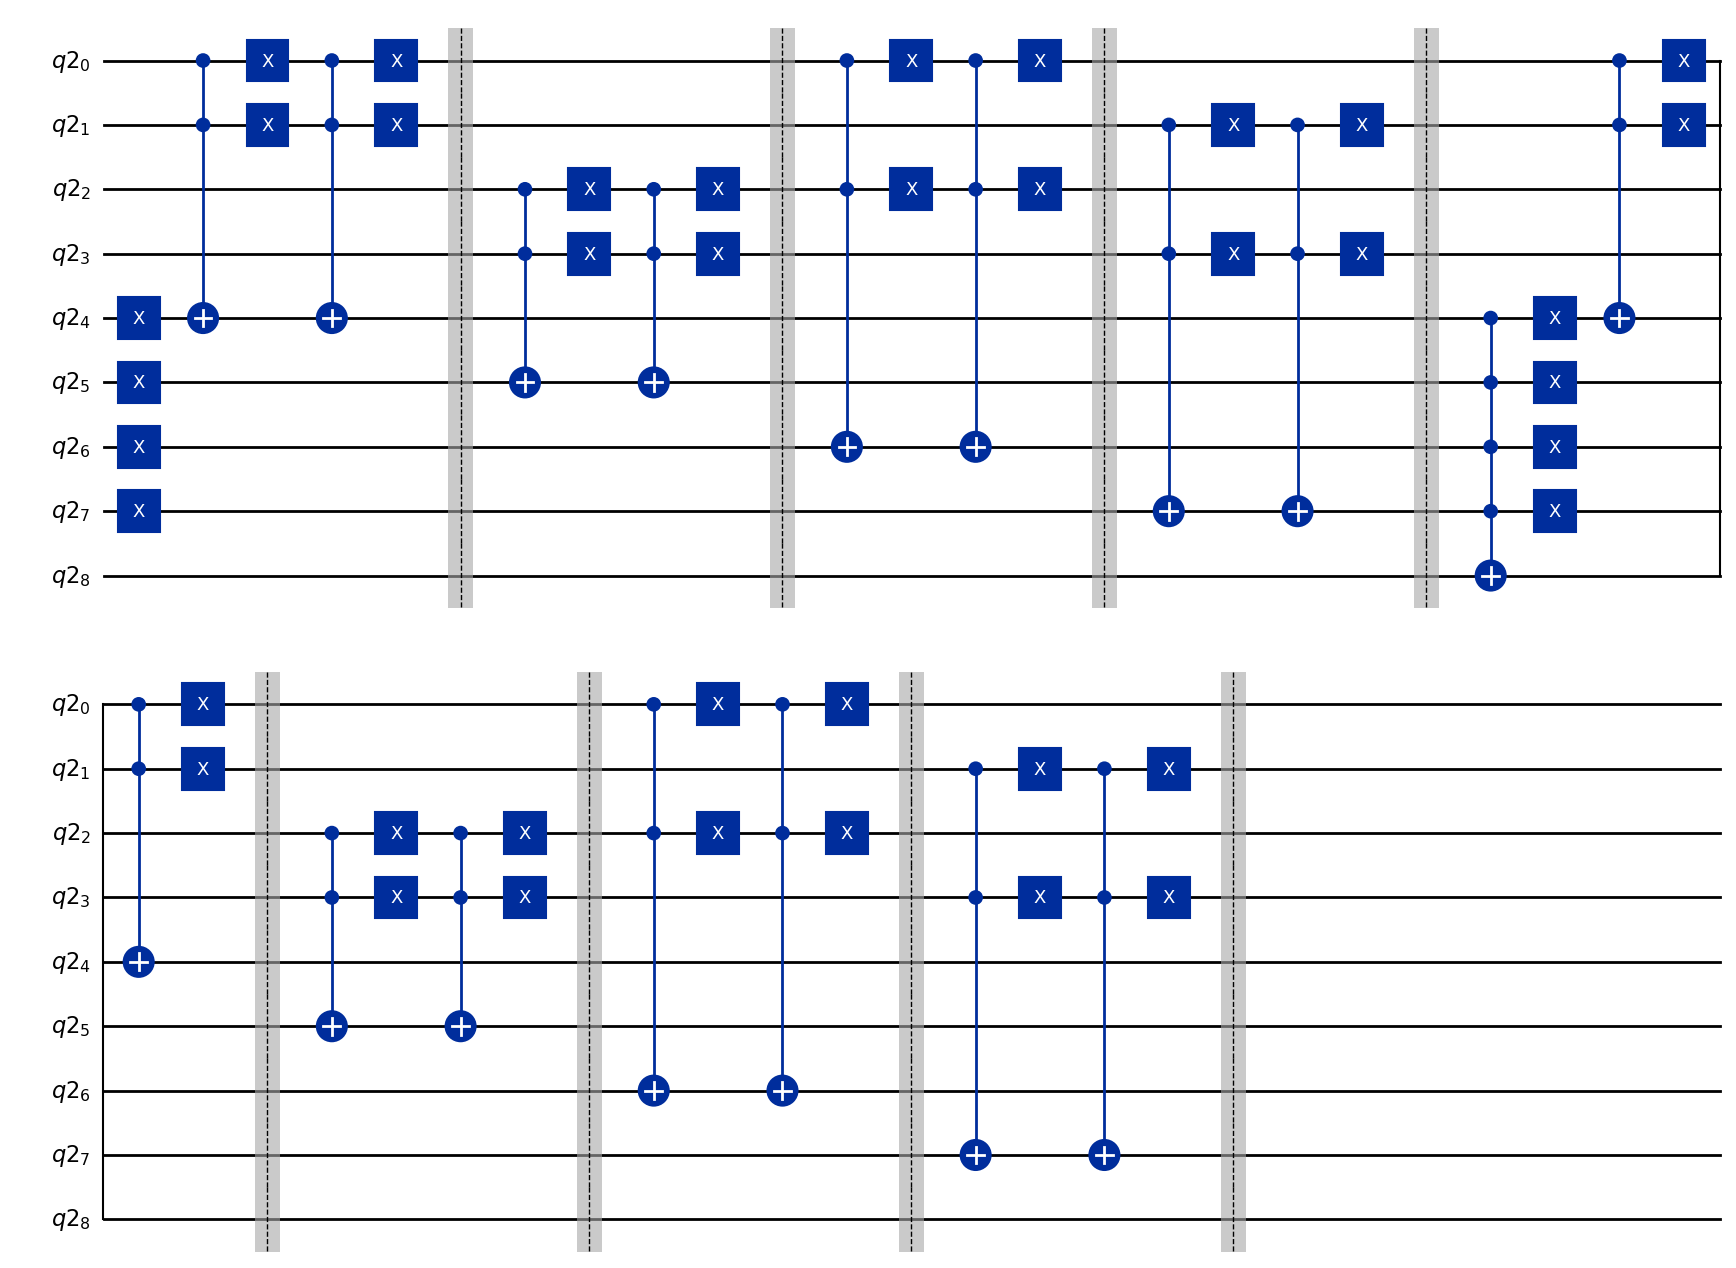

In [5]:
# We require 9 bits because we'll be doing the cnot implementation.
# The 4 input of the circuit is that {0,1} state of each cell
# we use 4 working bits to rrepresent the above 4 clauses
# and finally the last bit as the result.

# Logically, we know only the states 0110 and 1001 can be successful
# we'll have to verify the above 4 clauses
# we could do a non-genric solution in which we say b0 == b3, b1 == b2, and b0 != b1 which would satisfy the 2 solutions above with 3 clauses 
# but agian, does not translate into a full sudoku implementation well.

qr = QuantumRegister(9)
classical_oracle = QuantumCircuit(qr)
#we'll prepare it later
# classical_oracle.x(8)
# classical_oracle.h(8)

# do the bits
clauses(classical_oracle)

# Final CNOT:
c4x = XGate().control(4)

classical_oracle.append(c4x,[4,5,6,7,8] )

# unset the bits
clauses(classical_oracle)

# Draw
classical_oracle.draw(output='mpl')

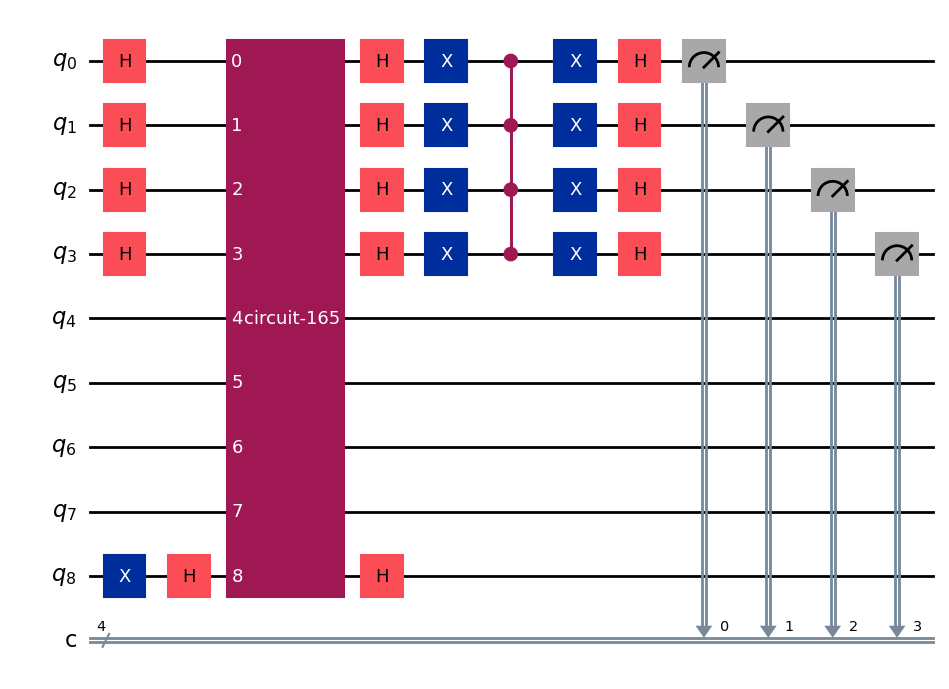

In [6]:
grovers = QuantumCircuit(9, 4)
# orcale bit = 1, superposition
grovers.x(8)
grovers.h(8)
# Create super position for inputs
for qubit in range(4):
    grovers.h(qubit)
grovers.append(classical_oracle, [0,1,2,3,4,5,6,7,8])

# Lets add the diffuser:
for qubit in range(4):
    grovers.h(qubit)
    grovers.x(qubit)
grovers.h(8)


c4z = ZGate().control(3)
grovers.append(c4z, [0,1,2,3])

for qubit in range(4): 
    grovers.x(qubit)
    grovers.h(qubit)

# finally measure
for qubit in range(4):
    grovers.measure(qubit, qubit)

grovers.draw(output='mpl')

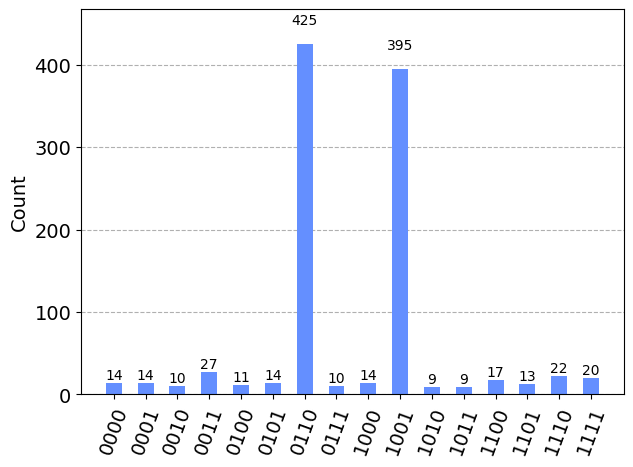

In [7]:
counts = AerSimulator().run(grovers.decompose()).result().get_counts()
plot_histogram(counts)